# ISLP - Chapter 10 - Exercise 11
### Author: pzuehlke

The solution will be almost identical to that of Exercise $ 10 $.
We begin by importing the necessary libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
from torchinfo import summary
from ISLP import load_data

Checking for a GPU:

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


Loading and preprocessing the NYSE data as in Exercise $ 10 $:

In [3]:
nyse = load_data("NYSE")
print(nyse.info())

# Extract the columns we need:
cols = ["DJ_return", "log_volume", "log_volatility"]
data = nyse[cols].copy()

# Create lagged features:
L = 5
for i in range(1, L + 1):
    for col in cols:
        data[f"{col}_{i}"] = data[col].shift(i)
data.dropna(inplace=True)

# Split the data chronologically:
data.index = pd.to_datetime(data.index)
cutoff_date = pd.to_datetime("1980-01-02")
train_data = data[data.index < cutoff_date]
test_data = data[data.index >= cutoff_date]

y_train = train_data["log_volume"]
y_test = test_data["log_volume"]

lag_cols = [f"{col}_{i}" for i in range(1, L + 1) for col in cols]
X_train = train_data[lag_cols]
X_test = test_data[lag_cols]

<class 'pandas.core.frame.DataFrame'>
Index: 6051 entries, 1962-12-03 to 1986-12-31
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   day_of_week     6051 non-null   category
 1   DJ_return       6051 non-null   float64 
 2   log_volume      6051 non-null   float64 
 3   log_volatility  6051 non-null   float64 
 4   train           6051 non-null   bool    
dtypes: bool(1), category(1), float64(3)
memory usage: 201.1+ KB
None


Next, we prepare the data in RNN format and convert it to tensors:

In [ ]:
# Reorganize and reshape for RNN format (time steps, features):
ordered_cols = [f"{col}_{i}" for i in range(L, 0, -1) for col in cols]
print(ordered_cols)

# Reindex to get proper column order:
X_ordered_train = X_train.reindex(columns=ordered_cols).values
X_ordered_test  = X_test.reindex(columns=ordered_cols).values

# Reshape to (samples, time_steps, features):
X_rnn_train = X_ordered_train.reshape(-1, L, len(cols))
X_rnn_test  = X_ordered_test.reshape(-1, L, len(cols))
print(X_rnn_train.shape)

# Convert to tensors:
X_train_tensor = torch.Tensor(X_rnn_train).to(device)
X_test_tensor  = torch.Tensor(X_rnn_test).to(device)
y_train_tensor = torch.Tensor(y_train.values).to(device)
y_test_tensor  = torch.Tensor(y_test.values).to(device)

# Create DataLoader:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)

['DJ_return_5', 'log_volume_5', 'log_volatility_5', 'DJ_return_4', 'log_volume_4', 'log_volatility_4', 'DJ_return_3', 'log_volume_3', 'log_volatility_3', 'DJ_return_2', 'log_volume_2', 'log_volatility_2', 'DJ_return_1', 'log_volume_1', 'log_volatility_1']
(4276, 5, 3)


Now we'll implement the nonlinear AR model. This is the only place where we'll
need to modify the code from Exercise $ 10 $, by including a hidden layer with
ReLU activation:

In [5]:
class NonlinearARNet(nn.Module):
    def __init__(self, input_size=3, time_steps=5, hidden_size=32, dropout_rate=0.5):
        super().__init__()
        # Flatten the 3D input (samples, time_steps, features):
        self.flatten = nn.Flatten()
        # Hidden layer with ReLU activation:
        self.hidden = nn.Linear(input_size * time_steps, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        # Output layer:
        self.output = nn.Linear(hidden_size, 1)
        

    def forward(self, x):
        # x shape: (batch, time_steps, features)
        x = self.flatten(x)  # shape: (batch, time_steps * features)
        x = self.hidden(x)   # shape: (batch, hidden_size)
        x = self.relu(x)     # nonlinear step
        x = self.dropout(x)
        x = self.output(x)   # shape: (batch, 1)
        return x.squeeze(-1)

Let's instantiate the model and check its structure:

In [6]:
model = NonlinearARNet().to(device)
summary(model)

Layer (type:depth-idx)                   Param #
NonlinearARNet                           --
├─Flatten: 1-1                           --
├─Linear: 1-2                            512
├─ReLU: 1-3                              --
├─Dropout: 1-4                           --
├─Linear: 1-5                            33
Total params: 545
Trainable params: 545
Non-trainable params: 0

Now we define the loss function and optimizer:

In [7]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Now we train the model. This code cell may take a lot of time to run:

In [ ]:
num_epochs = 1_000
losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        # Forward pass:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward and optimize:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    average_loss = epoch_loss / len(train_loader)
    losses.append(average_loss)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}]  "
              f"Loss: {average_loss:.4f}")

Epoch [100/1000]  Loss: 0.0278
Epoch [200/1000]  Loss: 0.0275
Epoch [300/1000]  Loss: 0.0271
Epoch [400/1000]  Loss: 0.0270
Epoch [500/1000]  Loss: 0.0266
Epoch [600/1000]  Loss: 0.0267
Epoch [700/1000]  Loss: 0.0269
Epoch [800/1000]  Loss: 0.0272
Epoch [900/1000]  Loss: 0.0275
Epoch [1000/1000]  Loss: 0.0263


Now we evaluate the model by computing its $ R^2 $ on the test set.
Then we plot actual and predicted log volumes in a time series covering
the test period.

PyTorch nonlinear AR model test R^2: 0.4159


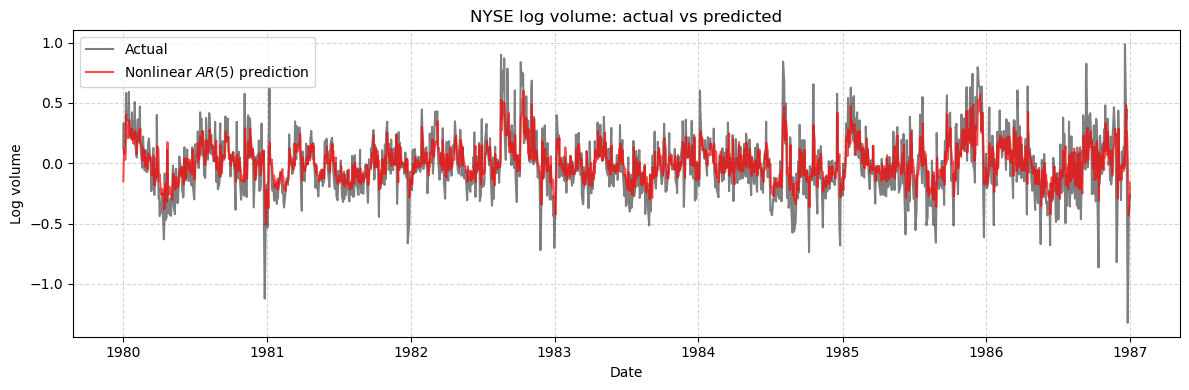

In [9]:
# Evaluate the model:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).cpu().numpy()

r2 = r2_score(y_test, y_test_pred)
print(f"PyTorch nonlinear AR model test R^2: {r2:.4f}")

# Compare predictions:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(test_data.index, y_test, label="Actual", color="black", alpha=0.5)
ax.plot(test_data.index, y_test_pred,
        label="Nonlinear $ AR(5) $ prediction", color="red", alpha=0.7)
ax.set_title("NYSE log volume: actual vs predicted")
ax.set_xlabel("Date")
ax.set_ylabel("Log volume")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)
fig.tight_layout()
plt.show()

This time, after several runs, I obtained values for the test $ R^2 $ in a tight
range between $ 0.39 $ and $ 0.41 $. Thus, this model seems to do better than
the linear AR model fit by PyTorch, but worse than the same linear model fit
using scikit-learn. However, here $ 1\,000 $ training epochs were used, instead
of the $ 200 $ for Exercise $ 9 $.